In [1]:
from vrae.vrae import VRAE
from vrae.utils import *
import numpy as np
import torch
import torch.nn as nn   
import pandas as pd
import plotly
from torch.utils.data import DataLoader, TensorDataset
plotly.offline.init_notebook_mode()
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from sklearn.model_selection import train_test_split


df = pd.read_pickle(fr'C:\Users\achfr\OneDrive - University of Edinburgh\Compiled dataset\df_compiled_mothers_labelled_cyclefate.csv')
df_tracks= df.pivot(values=[
    'GrowthRateSize','GrowthRateLength','GrowthRateFeretMax','GrowthRateFeretMaxSliding',
    'InterdivisionTimes','DivisionRate','DivisionRate_filtered','TrackLength','TrackLength_filtered',
    'Size','SizeAtBirthSize','FeretMax','SizeAtBirthFeretMax','MaxLength','SpineLength','SizeAtBirthLength','SpineWidth',
    'MeanIntensity_mch','MeanIntensity_gfp','Maxgfp',
    'BacteriaLineage','NextDivisionFrame','PreviousDivisionFrame',
    'TrackHeadIndices','Prev','Next','Idx','Frame','Indices','PositionIdx','cellcycle_fate'], 
    index=['Position','ParentTrackHeadIndices','Medium','Treatment','RepeatID','RepeatDate','fate','DeathSubtype'],
    columns='Time')

In [ ]:
#### Creating dataset and splitting it into train and test sets
liste_x=[]
liste_y=[]

for exp_name in ['gly_cip_1','gly_control_1','glu_cip_1','glu_control_1','gluaa_cip_1','gluaa_control_1']:

    medium,treatment,replicate = exp_name.split('_')

    frame = df_tracks.loc(axis=0)[:,:,medium,treatment,replicate]
    size_array = np.array([list(frame['FeretMax'].T[k]) for k in frame['FeretMax'].T.keys()])
    # size_array = TimeSeriesScalerMeanVariance().fit_transform(size_array)
    cyclefate_array = np.array([list(frame['cellcycle_fate'].T[k]) for k in frame['cellcycle_fate'].T.keys()])

    for i in range(size_array.shape[0]):
        size_serie =  size_array[i]
        ##fill nans missing timepoints with the mean of the previous and next timepoints
        for j in range(1,len(size_serie)-1):
            if np.isnan(size_serie[j]):
                size_serie[j] = np.mean([size_serie[j-1],size_serie[j+1]])
        cyclefate_serie = cyclefate_array[i]
        ##fill nans missing timepoints with the next fate timepoint
        for j in range(len(cyclefate_serie)-1):
            if cyclefate_serie[j] == 'nan':
                cyclefate_serie[j] = cyclefate_serie[j+1]

        t_death = len(cyclefate_serie)
        if np.where(cyclefate_serie != 'alive')[0].shape[0] > 0:
            t_death = np.where(cyclefate_serie != 'alive')[0][0]

        if t_death > 72:
            liste_x.append(size_serie[:72])
            liste_y.append((medium,treatment,replicate,t_death))

X = np.array(liste_x)
X = TimeSeriesScalerMeanVariance().fit_transform(X)
y = np.array(liste_y)

r = np.random.randint(0,X.shape[0])
serie = X[r]
print(liste_y[r])
plt.plot(np.arange(0,len(serie))/12,serie)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=True)

['gly' 'control' '1' '569']


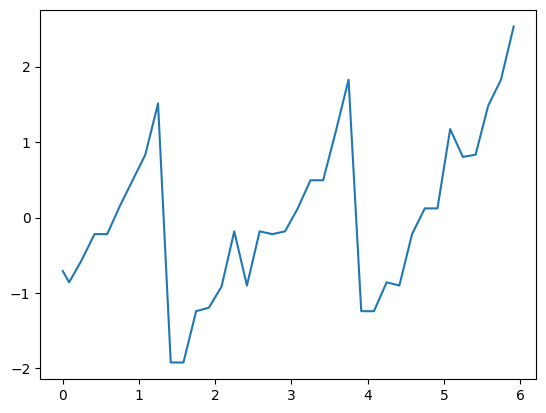

In [2]:
#### Creating dataset and splitting it into train and test sets then data augmentation
liste_x=[]
liste_y=[]

for exp_name in ['gly_cip_1','gly_control_1','glu_cip_1','glu_control_1','gluaa_cip_1','gluaa_control_1']:

    medium,treatment,replicate = exp_name.split('_')

    frame = df_tracks.loc(axis=0)[:,:,medium,treatment,replicate]
    size_array = np.array([list(frame['FeretMax'].T[k]) for k in frame['FeretMax'].T.keys()])
    # size_array = TimeSeriesScalerMeanVariance().fit_transform(size_array)
    cyclefate_array = np.array([list(frame['cellcycle_fate'].T[k]) for k in frame['cellcycle_fate'].T.keys()])

    for i in range(size_array.shape[0]):
        size_serie =  size_array[i]
        ##fill nans missing timepoints with the mean of the previous and next timepoints
        for j in range(1,len(size_serie)-1):
            if np.isnan(size_serie[j]):
                size_serie[j] = np.mean([size_serie[j-1],size_serie[j+1]])
        cyclefate_serie = cyclefate_array[i]
        ##fill nans missing timepoints with the next fate timepoint
        for j in range(len(cyclefate_serie)-1):
            if cyclefate_serie[j] == 'nan':
                cyclefate_serie[j] = cyclefate_serie[j+1]

        t_death = len(cyclefate_serie)
        if np.where(cyclefate_serie != 'alive')[0].shape[0] > 0:
            t_death = np.where(cyclefate_serie != 'alive')[0][0]

        usable_data = size_serie[:min(t_death,168)]

        if len(usable_data) > 72:
            liste_x.append(usable_data)
            liste_y.append((medium,treatment,replicate,t_death))

X_train_preaug, X_test_preaug, y_train_preaug, y_test_preaug = train_test_split(liste_x, liste_y, test_size=0.1, random_state=42, shuffle=True)

##### in X_train we change eahc sequence to series of size 72 with a roling window of 12
liste_x_train = []
liste_y_train = []
for i in range(len(X_train_preaug)):
    usable_data = X_train_preaug[i]
    for j in range(len(usable_data)-72):
        liste_x_train.append(usable_data[j:j+72])
        liste_y_train.append(y_train_preaug[i])
X_train = TimeSeriesScalerMeanVariance().fit_transform(np.array(liste_x_train))
y_train = np.array(liste_y_train)

##### in X_test we cut series to size 72
X_test = [x[:72] for x in X_test_preaug]
X_test = TimeSeriesScalerMeanVariance().fit_transform(np.array(X_test))
y_test = np.array(y_test_preaug)

r = np.random.randint(0,X_train.shape[0])
serie = X_train[r]
print(y_train[r])
plt.plot(np.arange(0,len(serie))/12,serie)

(94973, 72, 1)
torch.Size([200, 72, 1])
torch.Size([72, 200, 1])
torch.Size([72, 200, 1])


c:\USERS\ACHFR\.CONDA\ENVS\MLP\lib\site-packages\torch\nn\modules\rnn.py:67: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1

c:\USERS\ACHFR\.CONDA\ENVS\MLP\lib\site-packages\torch\nn\_reduction.py:42: UserWarning:

size_average and reduce args will be deprecated, please use reduction='sum' instead.



tensor(1854.5054, device='cuda:0', grad_fn=<MseLossBackward0>)

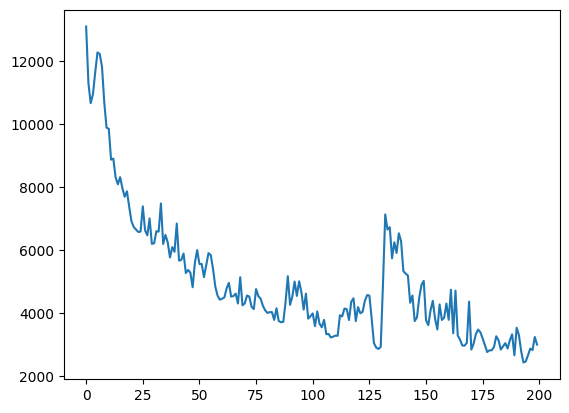

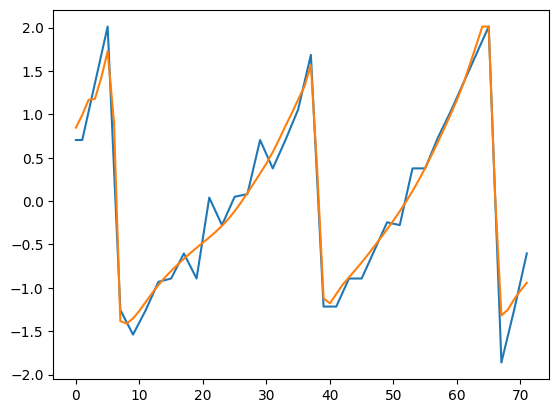

In [73]:
train_dataset = TensorDataset(torch.from_numpy(X_train))
test_dataset = TensorDataset(torch.from_numpy(X_test))

sequence_length = X_train.shape[1]
number_of_features = X_train.shape[2]

print(X_train.shape)

dload = './model_dir_mm' #download directory
hidden_size = 90
hidden_layer_depth = 1
latent_length = 20
batch_size = 200
learning_rate = 0.0005
n_epochs = 200
dropout_rate = 0.2
optimizer = 'Adam' # options: ADAM, SGD
cuda = True # options: True, False
print_every=200
clip = True # options: True, False
max_grad_norm=5
loss = 'MSELoss' # options: SmoothL1Loss, MSELoss
block = 'LSTM' # options: LSTM, GRU

vrae = VRAE(sequence_length=sequence_length,
            number_of_features = number_of_features,
            hidden_size = hidden_size, 
            hidden_layer_depth = hidden_layer_depth,
            latent_length = latent_length,
            batch_size = batch_size,
            learning_rate = learning_rate,
            n_epochs = n_epochs,
            dropout_rate = dropout_rate,
            optimizer = optimizer, 
            cuda = cuda,
            print_every=print_every, 
            clip=clip, 
            max_grad_norm=max_grad_norm,
            loss = loss,
            block = block,
            dload = dload)

# vrae.fit(train_dataset, save=True)
vrae.load(fr'C:\Users\achfr\timeseries-clustering-vae\model_dir_mm\model.pth')
file = open(fr'C:\Users\achfr\timeseries-clustering-vae\model_dir_mm\print.txt').readlines()
losses = []
for line in file:
    if 'Average loss' in line:
        losses.append(float(line.split(' ')[-1][:-2]))
plt.plot(losses)



vrae.eval()
testseq = train_dataset[30:batch_size+30][0].float()
print(testseq.shape)
# plt.plot(testseq[:,:,0].T)
testseq2 = testseq.permute(1, 0, 2).cuda()
print(testseq2.shape)
outp = vrae.forward(testseq2)
print(outp[0].shape)

k=np.random.randint(0,batch_size)
input_seq = testseq2[:,k,0].cpu().detach().numpy()
output_seq = outp[0][:,k,0].cpu().detach().numpy()
plt.figure()
plt.plot(input_seq.T)
plt.plot(output_seq.T)

loss = nn.MSELoss(reduction='sum')
loss(testseq2, outp[0])

torch.Size([200, 72, 1])
torch.Size([72, 200, 1])
torch.Size([72, 200, 1])


tensor(3.7074, device='cuda:0', grad_fn=<MseLossBackward0>)

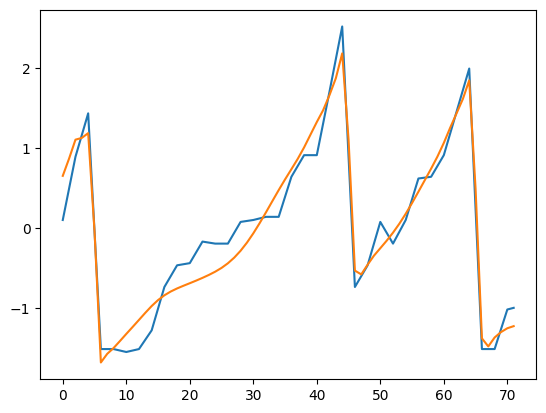

In [172]:
vrae.eval()
# testseq = train_dataset[30:batch_size+30][0].float()
testseq = test_dataset[:100][0].float()
testseq = testseq.repeat(2,1,1)

print(testseq.shape)
# plt.plot(testseq[:,:,0].T)
testseq2 = testseq.permute(1, 0, 2).cuda()
print(testseq2.shape)
outp = vrae.forward(testseq2)
print(outp[0].shape)

k=np.random.randint(0,batch_size)
input_seq = testseq2[:,k,0].cpu().detach().numpy()
output_seq = outp[0][:,k,0].cpu().detach().numpy()
plt.figure()
plt.plot(input_seq.T)
plt.plot(output_seq.T)

loss = nn.MSELoss(reduction='sum')
# loss(input_seq, output_seq)
loss(testseq2[:,k,0],outp[0][:,k,0])

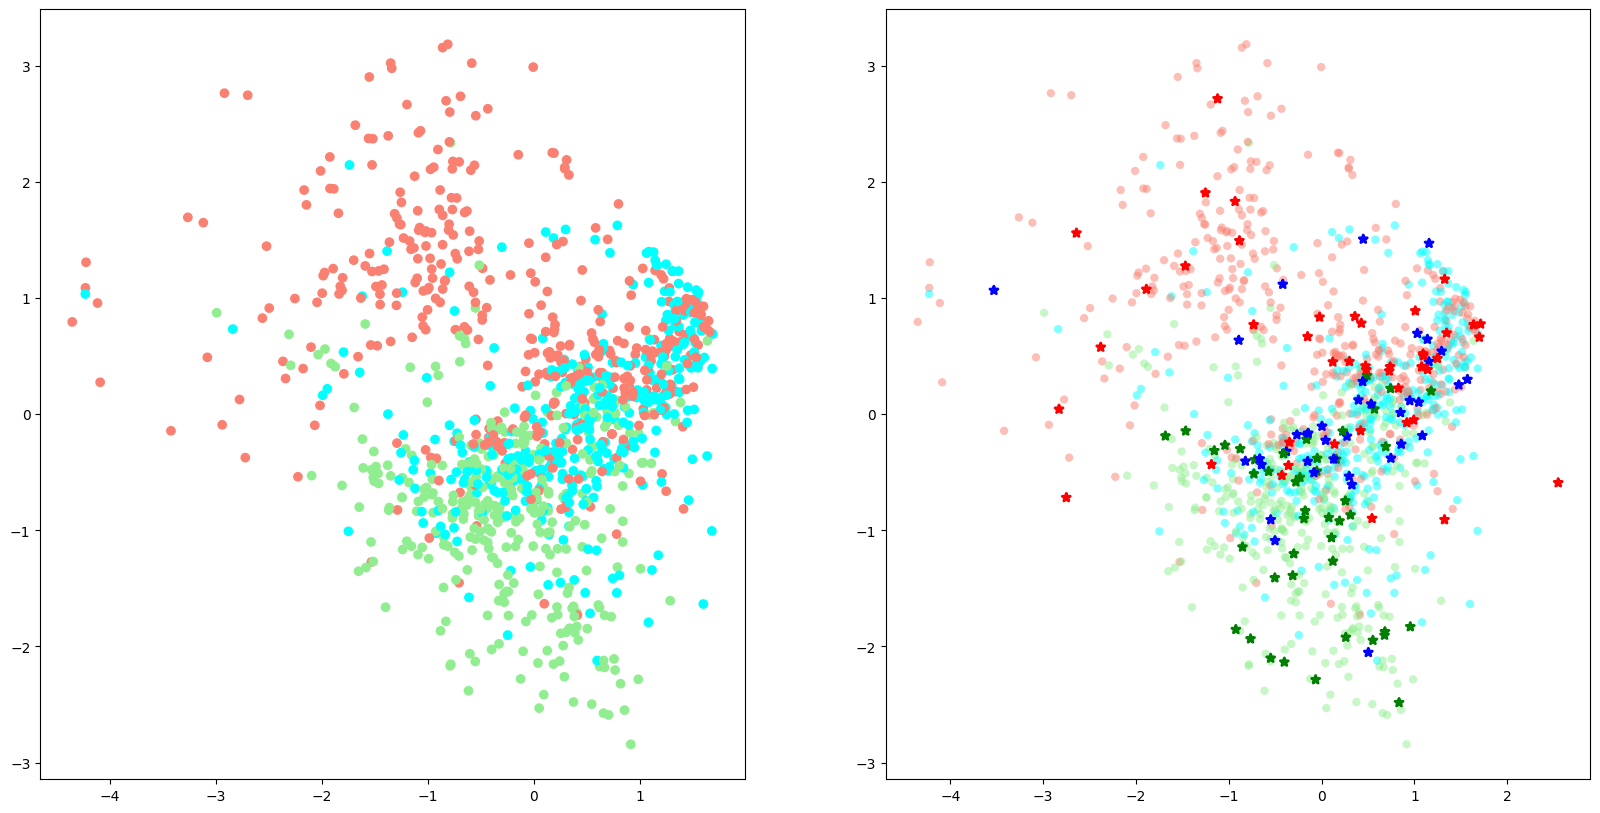

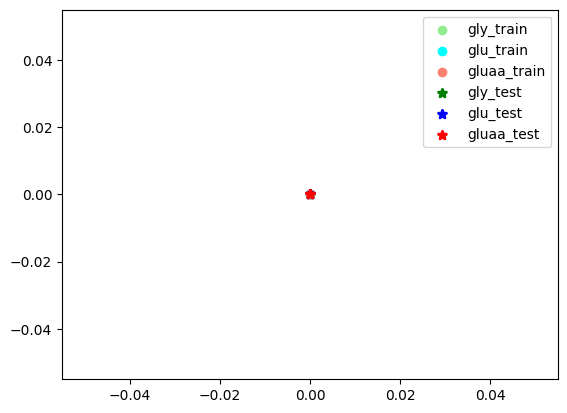

In [286]:
train_preaug_dataset = TensorDataset(torch.from_numpy(np.array([x[:72] for x in X_train_preaug])[:,:,None]))
test_preaug_dataset = TensorDataset(torch.from_numpy(np.array([x[:72] for x in X_test_preaug])[:,:,None]))

vrae.batch_size = 1
train_preaug_projected = vrae.transform(train_preaug_dataset)
test_preaug_projected = vrae.transform(test_preaug_dataset)
combined_preaug_projected = np.concatenate((train_preaug_projected,test_preaug_projected),0)


from sklearn.decomposition import TruncatedSVD,PCA
import seaborn as sns
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
combined_preaug_projected = scaler.fit_transform(combined_preaug_projected)

pca_fit = TruncatedSVD(n_components=20).fit(combined_preaug_projected)
pca = pca_fit.transform(combined_preaug_projected)

# from sklearn.manifold import TSNE
# tsne = TSNE(perplexity=50, min_grad_norm=1E-12, n_iter=3000).fit_transform(combined_preaug_projected)


fig, ax = plt.subplots(1, 2, figsize=(20, 10))
 
label_map = {'gly':'lightgreen','glu':'cyan','gluaa':'salmon'}
label_map_2 = {'gly':'green','glu':'blue','gluaa':'red'}
colors = [label_map[y[0]] for y in y_train_preaug]
colors_test = [label_map_2[y[0]] for y in y_test_preaug]

# ax[0].scatter(pca[:train_preaug_projected.shape[0], 0], pca[:train_preaug_projected.shape[0], 1], c=colors, marker='*', linewidths=0)
# ax[1].scatter(tsne[:train_preaug_projected.shape[0], 0], tsne[:train_preaug_projected.shape[0], 1], c=colors, marker='*', linewidths=1)

# r = np.random.randint(20)
# r2 = np.random.randint(20)
# print(r,r2)
r1,r2 = 8,16
ax[0].scatter(combined_preaug_projected[:train_preaug_projected.shape[0], r], combined_preaug_projected[:train_preaug_projected.shape[0], r2], c=colors, marker='o', linewidths=1)

ax[1].scatter(combined_preaug_projected[:train_preaug_projected.shape[0], r], combined_preaug_projected[:train_preaug_projected.shape[0], r2], c=colors, marker='o', linewidths=0, alpha=0.5)
#overlay test data
ax[1].scatter(combined_preaug_projected[train_preaug_projected.shape[0]:, r], combined_preaug_projected[train_preaug_projected.shape[0]:, r2], c=colors_test, marker='*', linewidths=2)

plt.figure()
plt.scatter((0,0),(0,0), marker='o', color = 'lightgreen', linewidths=1,label = 'gly_train')
plt.scatter((0,0),(0,0), marker='o', color = 'cyan', linewidths=1,label = 'glu_train')
plt.scatter((0,0),(0,0), marker='o', color = 'salmon', linewidths=1,label = 'gluaa_train')
plt.scatter((0,0),(0,0), marker='*', color = 'green', linewidths=2,label = 'gly_test')
plt.scatter((0,0),(0,0), marker='*', color = 'blue', linewidths=2,label = 'glu_test')
plt.scatter((0,0),(0,0), marker='*', color = 'red', linewidths=2,label = 'gluaa_test')
plt.legend()

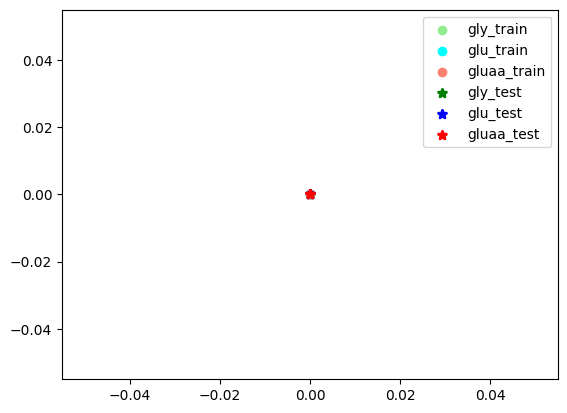

8 16


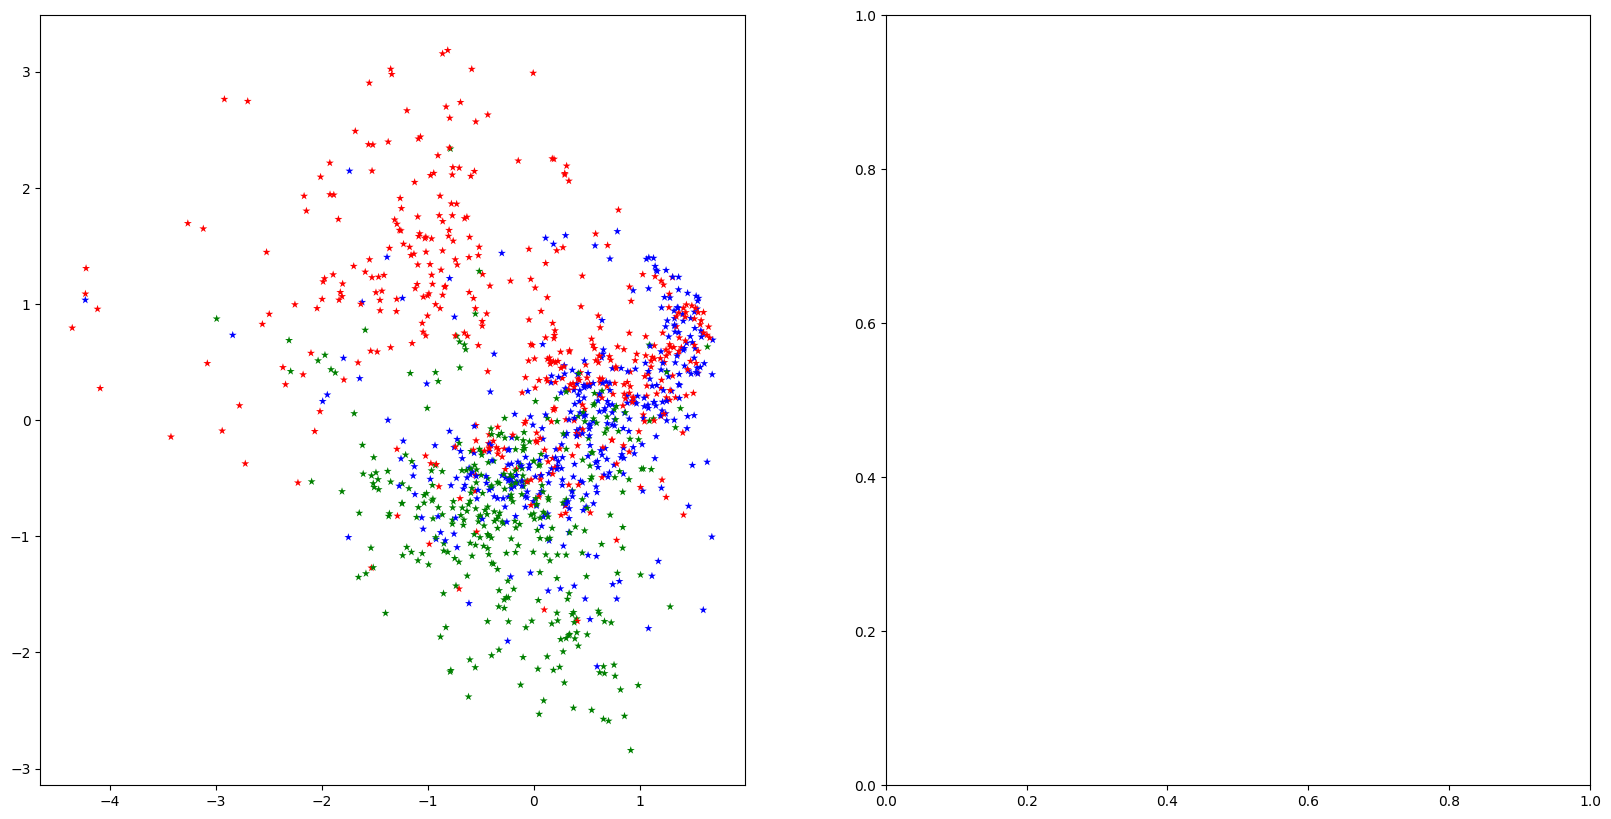

In [260]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
r = np.random.randint(20)
r2 = np.random.randint(20)
print(r,r2)
ax[0].scatter(combined_preaug_projected[:train_preaug_projected.shape[0], r], combined_preaug_projected[:train_preaug_projected.shape[0], r2], c=colors, marker='*', linewidths=0)



AttributeError: 'numpy.ndarray' object has no attribute 'unsqueeze'

In [ ]:
#### Embed everything

dataset_name_list = ['gly_control_1', 'gly_control_2', 'gly_control_3', 'gly_cip_1', 'gly_cip_2', 'gly_tet_1', 'gly_tet_2', 'gly_tet_3', 'gly_ciptet_1', 'gly_ciptet_2', 'glu_control_1', 'glu_control_2', 'glu_cip_1', 'glu_cip_2', 
 'glu_tet_1', 'glu_tet_2', 'glu_ciptet_1', 'glu_ciptet_2', 'gluaa_control_1', 'gluaa_control_2', 'gluaa_cip_1', 'gluaa_cip_2', 'gluaa_cip_3', 'gluaa_tet_1', 'gluaa_tet_2', 'gluaa_ciptet_1', 'gluaa_ciptet_2']
dataset_lengths = [188,376,304,252,307,317,277,411,328,431, 78,342,386,377,351,354,355,350,283,334,218,191,235,327,237,343,304]

liste_x=[]
liste_y=[]

for exp_name in dataset_name_list:
    print(exp_name)
    medium,treatment,replicate = exp_name.split('_')

    frame = df_tracks.loc(axis=0)[:,:,medium,treatment,replicate]
    size_array = np.array([list(frame['FeretMax'].T[k]) for k in frame['FeretMax'].T.keys()])
    cyclefate_array = np.array([list(frame['cellcycle_fate'].T[k]) for k in frame['cellcycle_fate'].T.keys()])

    for i in range(size_array.shape[0]):
        size_serie =  size_array[i]
        ##fill nans missing timepoints with the mean of the previous and next timepoints
        for j in range(1,len(size_serie)-1):
            if np.isnan(size_serie[j]):
                size_serie[j] = np.mean([size_serie[j-1],size_serie[j+1]])
        cyclefate_serie = cyclefate_array[i]
        ##fill nans missing timepoints with the next fate timepoint
        for j in range(len(cyclefate_serie)-1):
            if cyclefate_serie[j] == 'nan':
                cyclefate_serie[j] = cyclefate_serie[j+1]

        t_death = len(cyclefate_serie)
        if np.where(cyclefate_serie != 'alive')[0].shape[0] > 0:
            t_death = np.where(cyclefate_serie != 'alive')[0][0]

        usable_data = size_serie[:min(t_death,168)]

        if len(usable_data) > 72:
            liste_x.append(usable_data)
            liste_y.append((medium,treatment,replicate,t_death))

# Create the dataset
all_dataset = TensorDataset(torch.from_numpy(np.array([x[:72] for x in liste_x])))

label_map = {
    ('gly', 'control'): 0,
    ('gly', 'cip'): 1,
    ('gly', 'tet'): 2,
    ('gly', 'ciptet'): 3,
    ('glu', 'control'): 4,
    ('glu', 'cip'): 5,
    ('glu', 'tet'): 6,
    ('glu', 'ciptet'): 7,
    ('gluaa', 'control'): 8,
    ('gluaa', 'cip'): 9,
    ('gluaa', 'tet'): 10,
    ('gluaa', 'ciptet'): 11
}

labels = [label_map[k[:2]] for k in liste_y]